In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('..','config'), 'elsal_db_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()


import RecallAdjuster as ra
from importlib import reload
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


In [2]:
import datetime
from dateutil.relativedelta import relativedelta

base = datetime.datetime.strptime('2016-01-01', '%Y-%m-%d')   #Corresponding to latest train_end_time
date_pairs = []

# we can make x range to 20 months ago
for x in range(4, -1, -1):
    date_pairs.append(
        (
            (base - relativedelta(months=12*x) - relativedelta(months=12)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=12*x) - relativedelta(months=12)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
            (base - relativedelta(months=12*x) - relativedelta(months=12)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=12*x)).strftime('%Y-%m-%d')
        )
    )

for i in range(0, len(date_pairs), 2):
    print(date_pairs[i], date_pairs[i+1])

('2011-01-01', '2011-01-01') ('2011-01-01', '2012-01-01')
('2012-01-01', '2012-01-01') ('2012-01-01', '2013-01-01')
('2013-01-01', '2013-01-01') ('2013-01-01', '2014-01-01')
('2014-01-01', '2014-01-01') ('2014-01-01', '2015-01-01')
('2015-01-01', '2015-01-01') ('2015-01-01', '2016-01-01')


In [3]:
import time
import sys
import RecallAdjuster as ra

In [4]:
reload(ra)
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000],
        entity_demos='elsal',
        demo_col='gender',
        model_group_ids = [40],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

Running ELSal Pre-Recall Adjustment
Not running subsampling OR bootstrap based models
Time Taken=483.51040029525757


In [5]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_gender
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_m_to_f AS recall_m_to_f
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f
FROM bias_analysis.model_adjustment_results_gender r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas-0.24.2-py3.6-linux-x86_64.egg/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Value over Time')

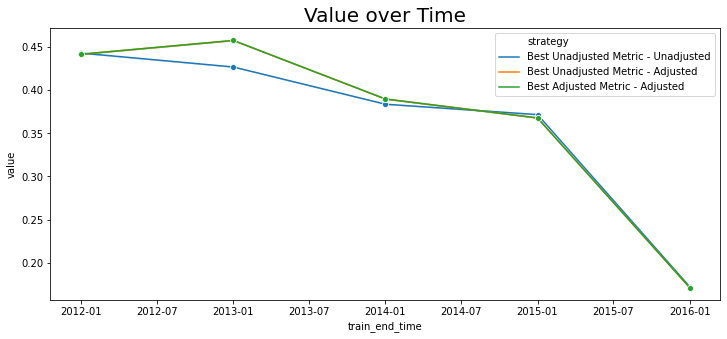

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value over Time", fontsize=20)

Text(0.5, 1.0, 'Max Recall Ratio')

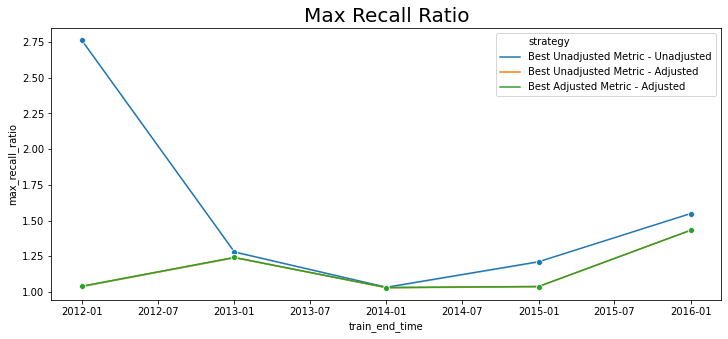

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Max Recall Ratio", fontsize=20)

Text(0.5, 1.0, 'Recall M to F')

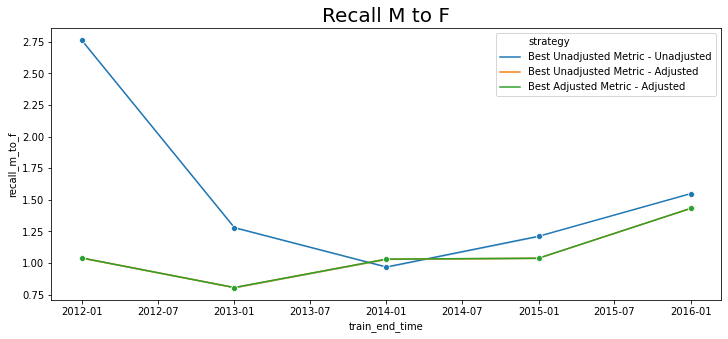

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_m_to_f', hue='strategy', marker="o", ax=ax)
plt.title("Recall M to F", fontsize=20)

In [9]:
ts_df.groupby(['strategy']).describe()

list_size                               \
                                        count    mean  std     min     25%   
strategy                                                                     
Best Adjusted Metric - Adjusted           9.0  1000.0  0.0  1000.0  1000.0   
Best Unadjusted Metric - Adjusted         9.0  1000.0  0.0  1000.0  1000.0   
Best Unadjusted Metric - Unadjusted       9.0  1000.0  0.0  1000.0  1000.0   

                                                            value            \
                                        50%     75%     max count      mean   
strategy                                                                      
Best Adjusted Metric - Adjusted      1000.0  1000.0  1000.0   9.0  0.387444   
Best Unadjusted Metric - Adjusted    1000.0  1000.0  1000.0   9.0  0.387444   
Best Unadjusted Metric - Unadjusted  1000.0  1000.0  1000.0   9.0  0.380553   

                                                                            \
                                          std       min       25%      50%   
strategy                                                                     
Best Adjusted Metric - Adjusted      0.089111  0.171000  0.368000  0.39000   
Best Unadjusted Metric - Adjusted    0.089111  0.171000  0.368000  0.39000   
Best Unadjusted Metric - Unadjusted  0.083541  0.172179  0.371901  0.38395   

                                                        max_recall_ratio  \
                                          75%       max            count   
strategy                                                                   
Best Adjusted Metric - Adjusted      0.442000  0.458000              9.0   
Best Unadjusted Metric - Adjusted    0.442000  0.458000              9.0   
Best Unadjusted Metric - Unadjusted  0.427184  0.443366              9.0   

                                                                             \
                                         mean       std       min       25%   
strategy                                                                      
Best Adjusted Metric - Adjusted      1.125556  0.145223  1.030580  1.037732   
Best Unadjusted Metric - Adjusted    1.125556  0.145223  1.030580  1.037732   
Best Unadjusted Metric - Unadjusted  1.568805  0.693004  1.032704  1.211250   

                                                                   \
                                          50%       75%       max   
strategy                                                            
Best Adjusted Metric - Adjusted      1.039670  1.241114  1.431808   
Best Unadjusted Metric - Adjusted    1.039670  1.241114  1.431808   
Best Unadjusted Metric - Unadjusted  1.279959  1.548739  2.761338   

                                    recall_m_to_f                      \
                                            count      mean       std   
strategy                                                                
Best Adjusted Metric - Adjusted               9.0  1.028803  0.181087   
Best Unadjusted Metric - Adjusted             9.0  1.028803  0.181087   
Best Unadjusted Metric - Unadjusted           9.0  1.554500  0.705915   

                                                                            \
                                          min      25%       50%       75%   
strategy                                                                     
Best Adjusted Metric - Adjusted      0.805728  1.03058  1.037732  1.039670   
Best Unadjusted Metric - Adjusted    0.805728  1.03058  1.037732  1.039670   
Best Unadjusted Metric - Unadjusted  0.968331  1.21125  1.279959  1.548739   

                                               
                                          max  
strategy                                       
Best Adjusted Metric - Adjusted      1.431808  
Best Unadjusted Metric - Adjusted    1.431808  
Best Unadjusted Metric - Unadjusted  2.761338

In [10]:
conn.dispose()
conn = connect()
reload(ra)

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


<module 'RecallAdjuster' from '/mnt/data/users/hemank/peeps-chili/code/RecallAdjuster.py'>

In [11]:
import time
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000,2500,5000,7500,10000],
        entity_demos='elsal',
        demo_col='gender',
        model_group_ids = [40],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

Running ELSal Pre-Recall Adjustment
Not running subsampling OR bootstrap based models
Time Taken=491.79257249832153


In [12]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_gender
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_m_to_f AS recall_m_to_f
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f
FROM bias_analysis.model_adjustment_results_gender r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

In [13]:
ts_df.groupby(['strategy','list_size']).describe()

value                      \
                                              count      mean       std   
strategy                            list_size                             
Best Adjusted Metric - Adjusted     1000        9.0  0.383333  0.085865   
                                    2500        9.0  0.381378  0.065856   
                                    5000        9.0  0.392044  0.067481   
                                    7500        9.0  0.384578  0.053379   
                                    10000       9.0  0.379333  0.045071   
Best Unadjusted Metric - Adjusted   1000        9.0  0.383333  0.085865   
                                    2500        9.0  0.381378  0.065856   
                                    5000        9.0  0.392044  0.067481   
                                    7500        9.0  0.384578  0.053379   
                                    10000       9.0  0.379333  0.045071   
Best Unadjusted Metric - Unadjusted 1000        9.0  0.381117  0.083272   
                                    2500        9.0  0.407570  0.098609   
                                    5000        9.0  0.381983  0.053622   
                                    7500        9.0  0.376340  0.046314   
                                    10000       9.0  0.372548  0.041377   

                                                                             \
                                                    min       25%       50%   
strategy                            list_size                                 
Best Adjusted Metric - Adjusted     1000       0.172000  0.368000  0.389000   
                                    2500       0.235600  0.346800  0.385200   
                                    5000       0.303600  0.337600  0.368000   
                                    7500       0.313733  0.342400  0.354133   
                                    10000      0.339300  0.342200  0.344300   
Best Unadjusted Metric - Adjusted   1000       0.172000  0.368000  0.389000   
                                    2500       0.235600  0.346800  0.385200   
                                    5000       0.303600  0.337600  0.368000   
                                    7500       0.313733  0.342400  0.354133   
                                    10000      0.339300  0.342200  0.344300   
Best Unadjusted Metric - Unadjusted 1000       0.173152  0.373554  0.383950   
                                    2500       0.231221  0.348270  0.397372   
                                    5000       0.309596  0.345679  0.361775   
                                    7500       0.319213  0.345176  0.346059   
                                    10000      0.328636  0.346784  0.347935   

                                                                   \
                                                    75%       max   
strategy                            list_size                       
Best Adjusted Metric - Adjusted     1000       0.430000  0.452000   
                                    2500       0.424800  0.441600   
                                    5000       0.413200  0.493600   
                                    7500       0.425467  0.451733   
                                    10000      0.415600  0.436700   
Best Unadjusted Metric - Adjusted   1000       0.430000  0.452000   
                                    2500       0.424800  0.441600   
                                    5000       0.413200  0.493600   
                                    7500       0.425467  0.451733   
                                    10000      0.415600  0.436700   
Best Unadjusted Metric - Unadjusted 1000       0.427184  0.443764   
                                    2500       0.426014  0.546799   
                                    5000       0.390534  0.466138   
                                    7500       0.398878  0.443808   
                                    10000      0.396323  0.430754   

                             

Text(0.5, 1.0, 'List Size Value')

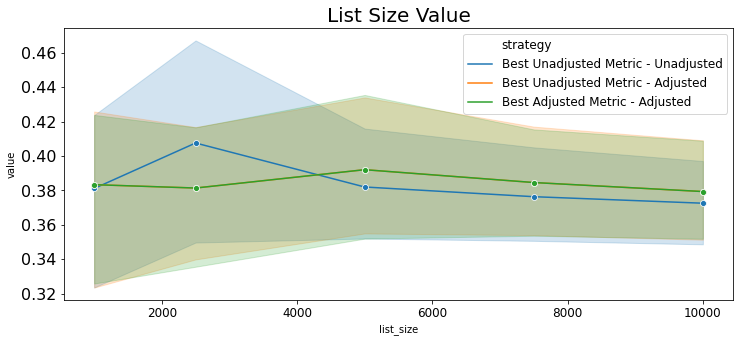

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)
#plt.savefig('../FIGURES/list_sizes_value.pdf')

Text(0.5, 1.0, 'List Sizes: Recall Male - Female')

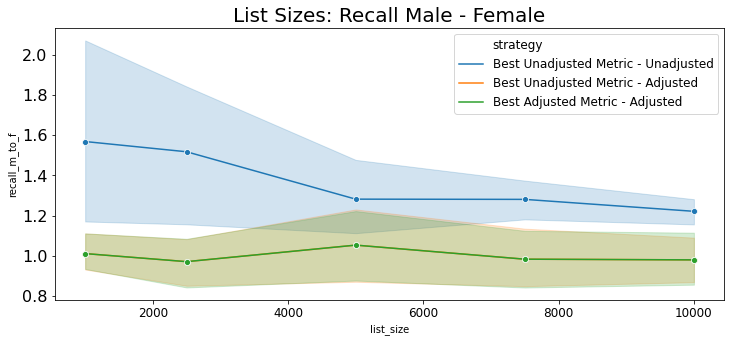

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_m_to_f', hue='strategy', marker="o", ax=ax)
plt.title("Recall Male to Female", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Sizes: Recall Male - Female", fontsize=20)
#plt.savefig('../FIGURES/list_sizes_recall_lm_highest.pdf')

In [16]:
query = "SELECT * from bias_analysis.model_adjustment_results_gender"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['model_id', 'model_group_id', 'train_end_time', 'list_size',
       'past_train_end_time', 'metric', 'parameter', 'base_value',
       'base_max_recall_ratio', 'base_recall_m_to_f', 'base_recall_f_to_m',
       'base_frac_m', 'base_recall_m', 'base_frac_f', 'base_recall_f',
       'adj_value', 'adj_max_recall_ratio', 'adj_recall_m_to_f',
       'adj_recall_f_to_m', 'adj_frac_m', 'adj_recall_m', 'adj_frac_f',
       'adj_recall_f', 'value_diff', 'recall_ratio_diff'],
      dtype='object')


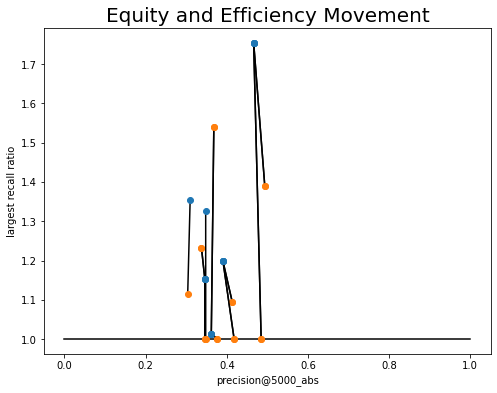

In [17]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@5000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

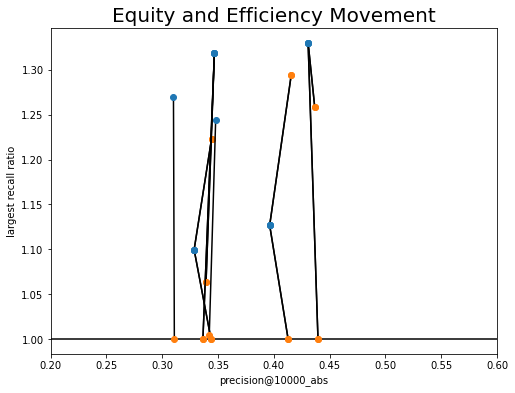

In [19]:
df_10000 = df[df['list_size']==10000]
arr = df_10000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@10000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

### Multiple Models -- Single List Size (Gender)

In [20]:
reload(ra)
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000],
        entity_demos='elsal',
        demo_col='gender',
        model_group_ids = [40,7,156],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

Running ELSal Pre-Recall Adjustment
Not running subsampling OR bootstrap based models
Time Taken=1378.8184823989868


In [33]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_gender
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_m_to_f AS recall_m_to_f,
       r.base_recall_f_to_m AS recall_f_to_m
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f,
       r.adj_recall_f_to_m AS recall_f_to_m
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f,
       r.adj_recall_f_to_m AS recall_f_to_m
FROM bias_analysis.model_adjustment_results_gender r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

Text(0.5, 1.0, 'Value over Time')

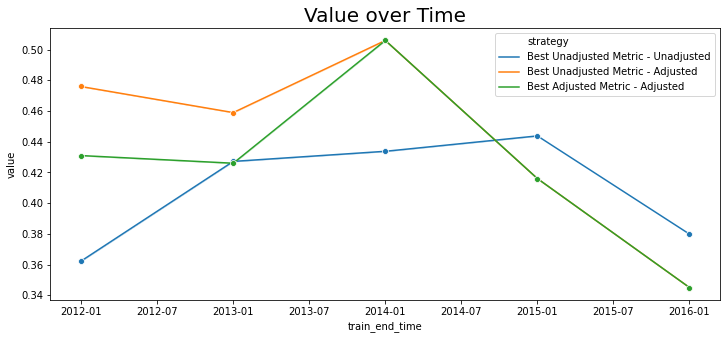

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value over Time", fontsize=20)

Text(0.5, 1.0, 'Max Recall Ratio')

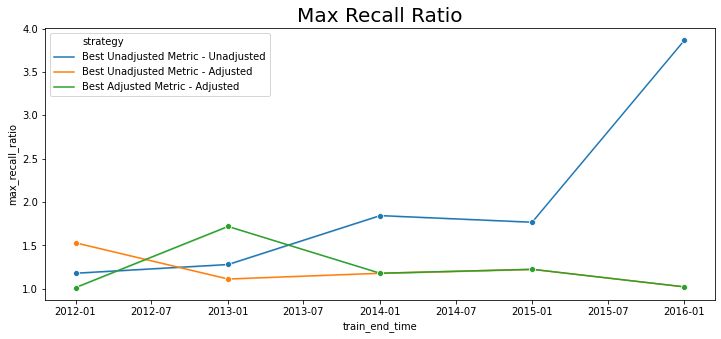

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Max Recall Ratio", fontsize=20)

Text(0.5, 1.0, 'Recall m to f (Gender)')

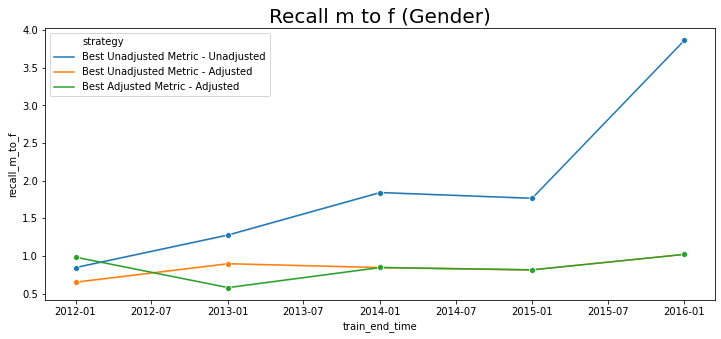

In [36]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_m_to_f', hue='strategy', marker="o", ax=ax)
plt.title("Recall m to f (Gender)", fontsize=20)

Text(0.5, 1.0, 'Recall f to m (Gender)')

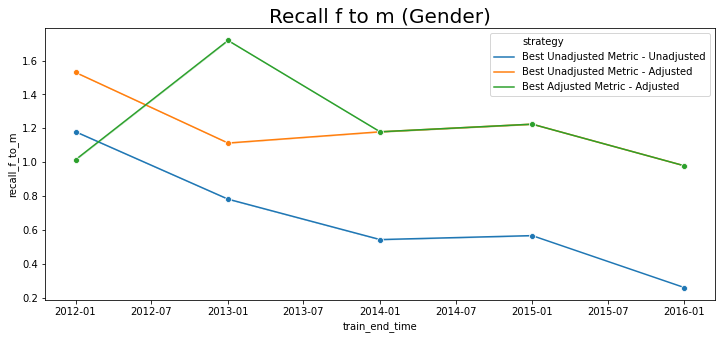

In [37]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_f_to_m', hue='strategy', marker="o", ax=ax)
plt.title("Recall f to m (Gender)", fontsize=20)

In [38]:
conn.dispose()
conn = connect()
reload(ra)

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


<module 'RecallAdjuster' from '/mnt/data/users/hemank/peeps-chili/code/RecallAdjuster.py'>

### Multiple Models - Multiple List Sizes - Gender

In [40]:
import time
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000,2500,5000,7500,10000],
        entity_demos='bias_analysis.entity_demos',
        demo_col='gender',
        model_group_ids = [40, 7, 156],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

Running ELSal Pre-Recall Adjustment
Not running subsampling OR bootstrap based models
Time Taken=1402.6986620426178


In [41]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_gender
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_m_to_f AS recall_m_to_f,
       r.base_recall_f_to_m AS recall_f_to_m
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f,
       r.adj_recall_f_to_m AS recall_f_to_m
FROM bias_analysis.model_adjustment_results_gender r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_m_to_f AS recall_m_to_f,
       r.adj_recall_f_to_m AS recall_f_to_m
FROM bias_analysis.model_adjustment_results_gender r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

In [42]:
ts_df.groupby(['strategy','list_size']).describe()

value                      \
                                              count      mean       std   
strategy                            list_size                             
Best Adjusted Metric - Adjusted     1000        9.0  0.419333  0.030241   
                                    2500        9.0  0.460133  0.034900   
                                    5000        9.0  0.432400  0.135901   
                                    7500        9.0  0.403200  0.134675   
                                    10000       9.0  0.397133  0.138693   
Best Unadjusted Metric - Adjusted   1000        9.0  0.462778  0.052163   
                                    2500        9.0  0.396222  0.147866   
                                    5000        9.0  0.424800  0.134866   
                                    7500        9.0  0.403200  0.134675   
                                    10000       9.0  0.396889  0.138615   
Best Unadjusted Metric - Unadjusted 1000        9.0  0.419613  0.042743   
                                    2500        9.0  0.437699  0.187970   
                                    5000        9.0  0.396466  0.159390   
                                    7500        9.0  0.391878  0.151669   
                                    10000       9.0  0.393054  0.146751   

                                                                             \
                                                    min       25%       50%   
strategy                            list_size                                 
Best Adjusted Metric - Adjusted     1000       0.370000  0.387000  0.426000   
                                    2500       0.425200  0.428400  0.458000   
                                    5000       0.198000  0.469400  0.479200   
                                    7500       0.170533  0.432800  0.456667   
                                    10000      0.156900  0.437000  0.456700   
Best Unadjusted Metric - Adjusted   1000       0.345000  0.451000  0.460000   
                                    2500       0.140800  0.425200  0.458000   
                                    5000       0.198000  0.410800  0.469400   
                                    7500       0.170533  0.432800  0.456667   
                                    10000      0.156900  0.435900  0.456700   
Best Unadjusted Metric - Unadjusted 1000       0.362109  0.379803  0.427184   
                                    2500       0.108714  0.476719  0.524487   
                                    5000       0.120433  0.427196  0.461466   
                                    7500       0.128266  0.439379  0.453455   
                                    10000      0.138064  0.438898  0.450089   

                                                                   \
                                                    75%       max   
strategy                            list_size                       
Best Adjusted Metric - Adjusted     1000       0.438000  0.451000   
                                    2500       0.480800  0.507200   
                                    5000       0.493600  0.545200   
                                    7500       0.457067  0.513733   
                                    10000      0.456800  0.508100   
Best Unadjusted Metric - Adjusted   1000       0.476000  0.523000   
                                    2500       0.480800  0.507200   
                                    5000       0.493600  0.545200   
                                    7500       0.457067  0.513733   
                                    10000      0.456800  0.508100   
Best Unadjusted Metric - Unadjusted 1000       0.435656  0.473409   
                                    2500       0.546799  0.551288   
                                    5000       0.466138  0.522461   
                                    7500       0.467740  0.508483   
                                    10000      0.473073  0.505157   

                             

Text(0.5, 1.0, 'List Size Value')

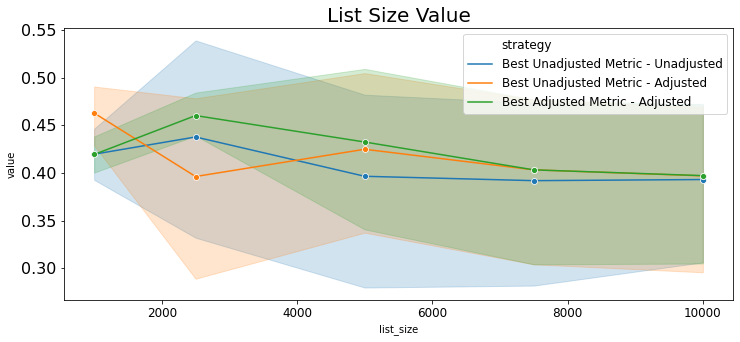

In [43]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)
#plt.savefig('../FIGURES/list_sizes_value.pdf')

Text(0.5, 1.0, 'List Sizes: Recall Ratio')

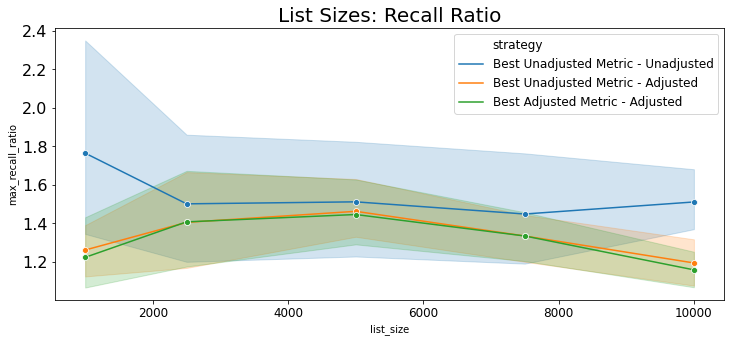

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Recall 0 to 1", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Sizes: Recall Ratio", fontsize=20)
#plt.savefig('../FIGURES/list_sizes_recall_lm_highest.pdf')

Text(0.5, 1.0, 'List Sizes: Recall M to F')

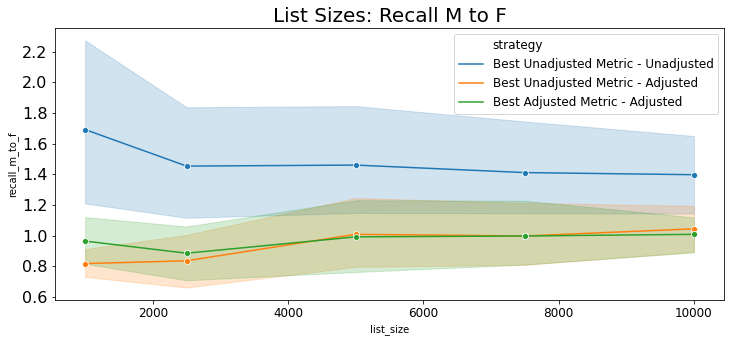

In [47]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_m_to_f', hue='strategy', marker="o", ax=ax)
plt.title("Recall M to F", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Sizes: Recall M to F", fontsize=20)

In [48]:
query = "SELECT * from bias_analysis.model_adjustment_results_gender"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['model_id', 'model_group_id', 'train_end_time', 'list_size',
       'past_train_end_time', 'metric', 'parameter', 'base_value',
       'base_max_recall_ratio', 'base_recall_m_to_f', 'base_recall_f_to_m',
       'base_frac_m', 'base_recall_m', 'base_frac_f', 'base_recall_f',
       'adj_value', 'adj_max_recall_ratio', 'adj_recall_m_to_f',
       'adj_recall_f_to_m', 'adj_frac_m', 'adj_recall_m', 'adj_frac_f',
       'adj_recall_f', 'value_diff', 'recall_ratio_diff'],
      dtype='object')


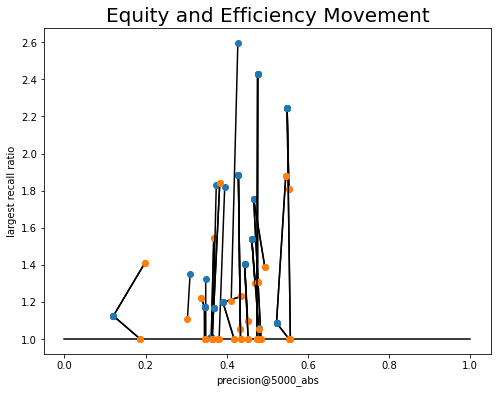

In [49]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@5000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

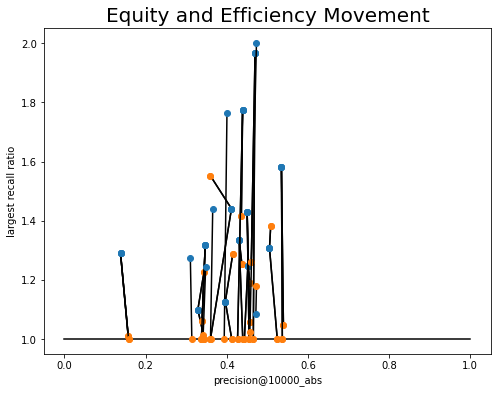

In [50]:
df_10000 = df[df['list_size']==10000]
arr = df_10000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@10000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

### Multiple List Sizes -  Multiple Models - Overage

In [51]:
conn.dispose()
conn = connect()
reload(ra)
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000,2500,5000,7500,10000],
        entity_demos='bias_analysis.entity_demos',
        demo_col='ovg',
        model_group_ids = [40, 7, 156],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


Running ELSal Pre-Recall Adjustment
Not running subsampling OR bootstrap based models
Time Taken=1416.4527332782745


In [53]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_ovg
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_0_to_1 AS recall_0_to_1,
       r.base_recall_1_to_0 AS recall_1_to_0
FROM bias_analysis.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM bias_analysis.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_0_to_1 AS recall_0_to_1,
       r.adj_recall_1_to_0 AS recall_1_to_0
FROM bias_analysis.model_adjustment_results_ovg r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

In [54]:
ts_df.groupby(['strategy','list_size']).describe()

value                      \
                                              count      mean       std   
strategy                            list_size                             
Best Adjusted Metric - Adjusted     1000        8.0  0.384000  0.124366   
                                    2500        9.0  0.380356  0.103064   
                                    5000        9.0  0.392133  0.118267   
                                    7500        9.0  0.389422  0.115813   
                                    10000       9.0  0.401622  0.121343   
Best Unadjusted Metric - Adjusted   1000        8.0  0.443250  0.146633   
                                    2500        9.0  0.393689  0.127372   
                                    5000        9.0  0.397578  0.120465   
                                    7500        9.0  0.392741  0.117214   
                                    10000       9.0  0.400878  0.120894   
Best Unadjusted Metric - Unadjusted 1000        8.0  0.424947  0.043293   
                                    2500        9.0  0.419682  0.138524   
                                    5000        9.0  0.430447  0.105010   
                                    7500        9.0  0.420781  0.095392   
                                    10000       9.0  0.423164  0.106941   

                                                                             \
                                                    min       25%       50%   
strategy                            list_size                                 
Best Adjusted Metric - Adjusted     1000       0.225000  0.309750  0.385500   
                                    2500       0.215600  0.362800  0.431600   
                                    5000       0.192000  0.408200  0.431200   
                                    7500       0.190000  0.419333  0.427333   
                                    10000      0.198200  0.427400  0.427500   
Best Unadjusted Metric - Adjusted   1000       0.338000  0.354500  0.378500   
                                    2500       0.215600  0.362800  0.410400   
                                    5000       0.192000  0.408200  0.448200   
                                    7500       0.190000  0.419333  0.442267   
                                    10000      0.198200  0.427400  0.427500   
Best Unadjusted Metric - Unadjusted 1000       0.362109  0.410916  0.431405   
                                    2500       0.198242  0.397372  0.445864   
                                    5000       0.246919  0.466138  0.475832   
                                    7500       0.255349  0.443588  0.467740   
                                    10000      0.239694  0.438898  0.474937   

                                                                   \
                                                    75%       max   
strategy                            list_size                       
Best Adjusted Metric - Adjusted     1000       0.459750  0.540000   
                                    2500       0.432000  0.485600   
                                    5000       0.483200  0.500000   
                                    7500       0.476000  0.479467   
                                    10000      0.469600  0.519400   
Best Unadjusted Metric - Adjusted   1000       0.467250  0.678000   
                                    2500       0.423200  0.571200   
                                    5000       0.481600  0.483200   
                                    7500       0.476000  0.479467   
                                    10000      0.462900  0.519400   
Best Unadjusted Metric - Unadjusted 1000       0.445436  0.474870   
                                    2500       0.523223  0.546799   
                                    5000       0.480942  0.505097   
                                    7500       0.467896  0.492810   
                                    10000      0.484478  0.508469   

                             

Text(0.5, 1.0, 'Value over Time')

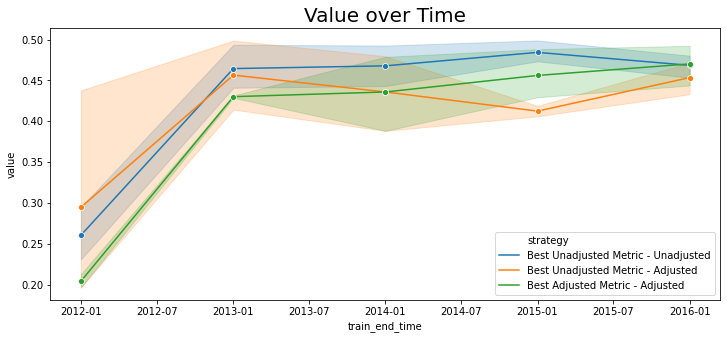

In [55]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value over Time", fontsize=20)

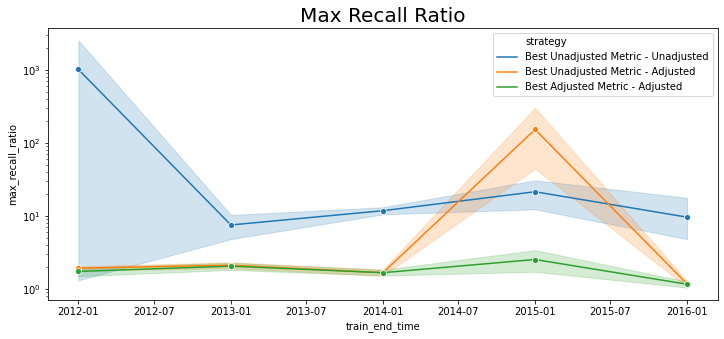

In [59]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Max Recall Ratio", fontsize=20)
plt.gca().set_yscale('log')

Text(0.5, 1.0, 'Recall - 0 to 1 (Overage)')

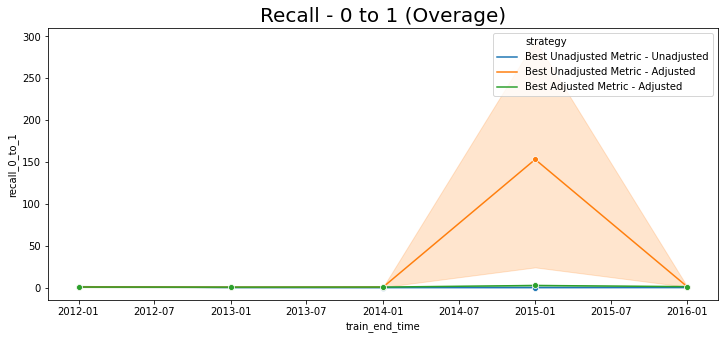

In [60]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_0_to_1', hue='strategy', marker="o", ax=ax)
plt.title("Recall - 0 to 1 (Overage)", fontsize=20)

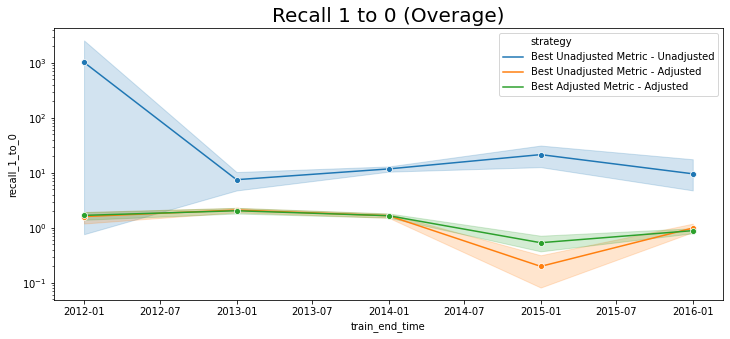

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_1_to_0', hue='strategy', marker="o", ax=ax)
plt.title("Recall 1 to 0 (Overage)", fontsize=20)
plt.gca().set_yscale('log')

In [63]:
query = "SELECT * from bias_analysis.model_adjustment_results_ovg"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['model_id', 'model_group_id', 'train_end_time', 'list_size',
       'past_train_end_time', 'metric', 'parameter', 'base_value',
       'base_max_recall_ratio', 'base_recall_0_to_1', 'base_recall_1_to_0',
       'base_frac_0', 'base_recall_0', 'base_frac_1', 'base_recall_1',
       'adj_value', 'adj_max_recall_ratio', 'adj_recall_0_to_1',
       'adj_recall_1_to_0', 'adj_frac_0', 'adj_recall_0', 'adj_frac_1',
       'adj_recall_1', 'value_diff', 'recall_ratio_diff'],
      dtype='object')


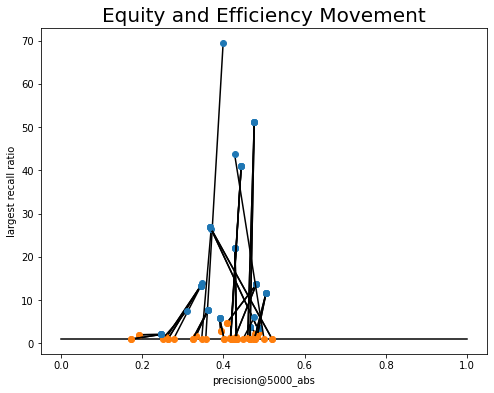

In [64]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@5000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

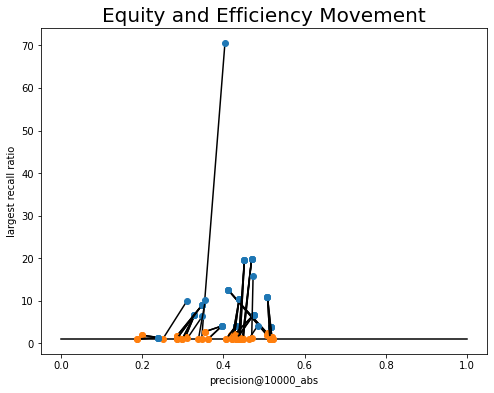

In [65]:
df_10000 = df[df['list_size']==10000]
arr = df_10000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@10000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

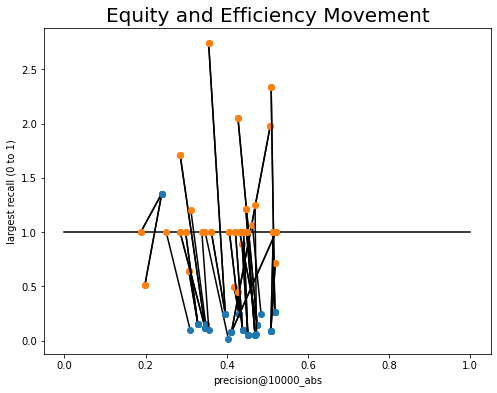

In [68]:
df_10000 = df[df['list_size']==10000]
arr = df_10000[['base_value', 'base_recall_0_to_1', 'adj_value', 'adj_recall_0_to_1']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@10000_abs')
ax.set_ylabel('largest recall (0 to 1)')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

### Multiple List Sizes - Rural

In [69]:
conn.dispose()
conn = connect()
reload(ra)
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000,2500,5000,7500,10000],
        entity_demos='bias_analysis.entity_demos',
        demo_col='rural',
        model_group_ids = [40, 7, 156],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


Running ELSal Pre-Recall Adjustment
Not executing Entity Demos -- picking up from previously built schema.
Not running subsampling OR bootstrap based models
Time Taken=1333.7504196166992


In [70]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_rural
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_rural_to_urban AS recall_rural_to_urban,
       r.base_recall_unknown_to_rural AS recall_unknown_to_rural,
       r.base_recall_unknown_to_urban AS recall_unknown_to_urban
FROM bias_analysis.model_adjustment_results_rural r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_rural_to_urban AS recall_rural_to_urban,
       r.adj_recall_unknown_to_rural AS recall_unknown_to_rural,
       r.adj_recall_unknown_to_urban AS recall_unknown_to_urban
FROM bias_analysis.model_adjustment_results_rural r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_rural_to_urban AS recall_rural_to_urban,
       r.adj_recall_unknown_to_rural AS recall_unknown_to_rural,
       r.adj_recall_unknown_to_urban AS recall_unknown_to_urban
FROM bias_analysis.model_adjustment_results_rural r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

In [71]:
ts_df.groupby(['strategy', 'list_size']).describe()

value                      \
                                              count      mean       std   
strategy                            list_size                             
Best Adjusted Metric - Adjusted     1000        9.0  0.486000  0.051901   
                                    2500        9.0  0.462844  0.077536   
                                    5000        9.0  0.374489  0.107240   
                                    7500        9.0  0.411956  0.123093   
                                    10000       9.0  0.401300  0.120305   
Best Unadjusted Metric - Adjusted   1000        9.0  0.490000  0.046699   
                                    2500        9.0  0.463556  0.077561   
                                    5000        9.0  0.432711  0.138403   
                                    7500        9.0  0.434563  0.131976   
                                    10000       9.0  0.401300  0.120305   
Best Unadjusted Metric - Unadjusted 1000        9.0  0.413446  0.035121   
                                    2500        9.0  0.457280  0.080546   
                                    5000        9.0  0.411118  0.127404   
                                    7500        9.0  0.408012  0.130409   
                                    10000       9.0  0.405146  0.135057   

                                                                             \
                                                    min       25%       50%   
strategy                            list_size                                 
Best Adjusted Metric - Adjusted     1000       0.422000  0.452000  0.464000   
                                    2500       0.372400  0.399600  0.462400   
                                    5000       0.198200  0.372200  0.422600   
                                    7500       0.210933  0.416933  0.439200   
                                    10000      0.205100  0.401700  0.432200   
Best Unadjusted Metric - Adjusted   1000       0.440000  0.452000  0.464000   
                                    2500       0.372400  0.399600  0.468800   
                                    5000       0.198200  0.441000  0.502400   
                                    7500       0.210933  0.439200  0.500400   
                                    10000      0.205100  0.401700  0.432200   
Best Unadjusted Metric - Unadjusted 1000       0.362109  0.379803  0.427184   
                                    2500       0.356286  0.397372  0.473214   
                                    5000       0.191863  0.427362  0.461701   
                                    7500       0.182549  0.443478  0.462294   
                                    10000      0.171564  0.438898  0.463594   

                                                                   \
                                                    75%       max   
strategy                            list_size                       
Best Adjusted Metric - Adjusted     1000       0.525000  0.550000   
                                    2500       0.536400  0.543200   
                                    5000       0.441000  0.502400   
                                    7500       0.500400  0.536533   
                                    10000      0.490700  0.521500   
Best Unadjusted Metric - Adjusted   1000       0.525000  0.550000   
                                    2500       0.536400  0.543200   
                                    5000       0.508200  0.548600   
                                    7500       0.518667  0.536533   
                                    10000      0.490700  0.521500   
Best Unadjusted Metric - Unadjusted 1000       0.435028  0.446281   
                                    2500       0.520695  0.546799   
                                    5000       0.466138  0.516650   
                                    7500       0.467740  0.513861   
                                    10000      0.473073  0.512565   

                             

Text(0.5, 1.0, 'List Size Value')

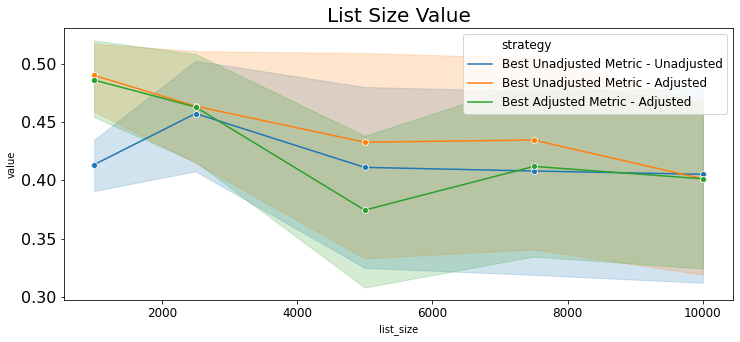

In [72]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

Text(0.5, 1.0, 'List Size Value')

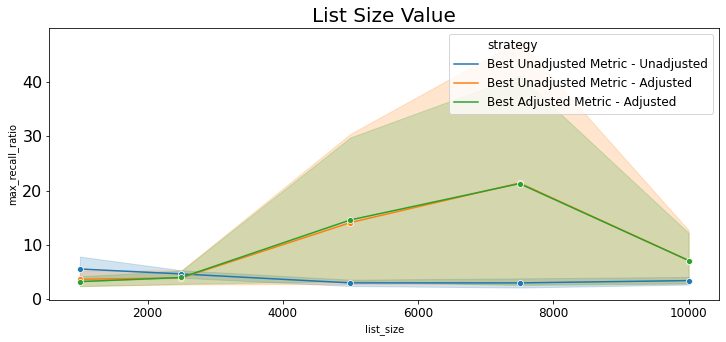

In [73]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

Text(0.5, 1.0, 'List Size Value')

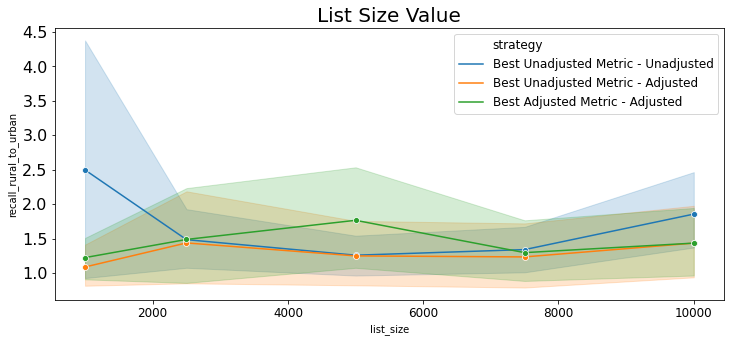

In [74]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_rural_to_urban', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

Text(0.5, 1.0, 'List Size Value')

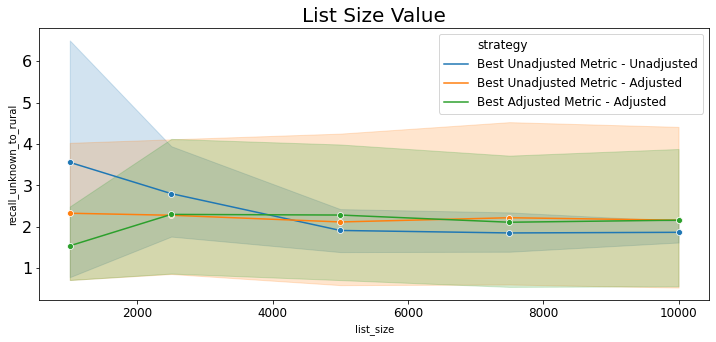

In [76]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_unknown_to_rural', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

Text(0.5, 1.0, 'List Size Value')

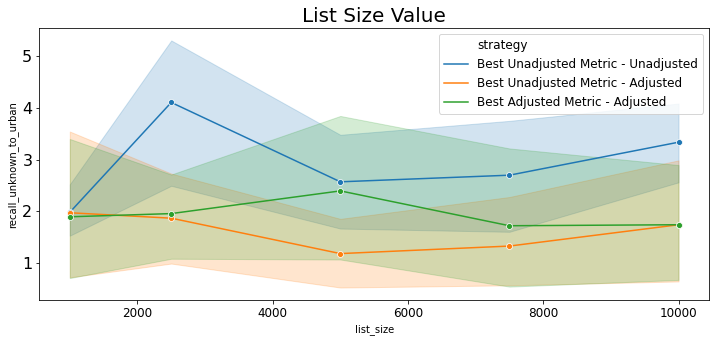

In [77]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_unknown_to_urban', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

In [78]:
query = "SELECT * from bias_analysis.model_adjustment_results_rural"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['model_id', 'model_group_id', 'train_end_time', 'list_size',
       'past_train_end_time', 'metric', 'parameter', 'base_value',
       'base_max_recall_ratio', 'base_recall_urban_to_rural',
       'base_recall_urban_to_unknown', 'base_recall_rural_to_urban',
       'base_recall_rural_to_unknown', 'base_recall_unknown_to_urban',
       'base_recall_unknown_to_rural', 'base_frac_urban', 'base_recall_urban',
       'base_frac_rural', 'base_recall_rural', 'base_frac_unknown',
       'base_recall_unknown', 'adj_value', 'adj_max_recall_ratio',
       'adj_recall_urban_to_rural', 'adj_recall_urban_to_unknown',
       'adj_recall_rural_to_urban', 'adj_recall_rural_to_unknown',
       'adj_recall_unknown_to_urban', 'adj_recall_unknown_to_rural',
       'adj_frac_urban', 'adj_recall_urban', 'adj_frac_rural',
       'adj_recall_rural', 'adj_frac_unknown', 'adj_recall_unknown',
       'value_diff', 'recall_ratio_diff'],
      dtype='object')


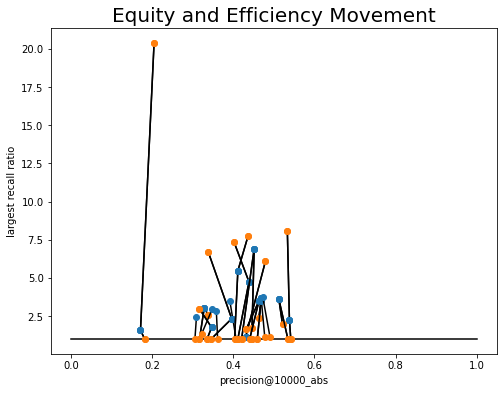

In [79]:
df_10000 = df[df['list_size']==10000]
arr = df_10000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@10000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

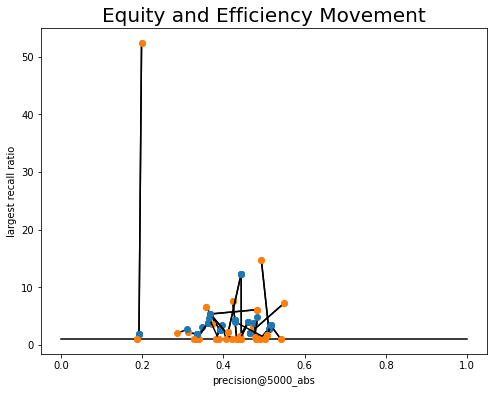

In [80]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@5000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

### Rural Code has a problem --- maybe the models are optimizing on 3way demographics - rural, urban, unknown
#### We can probably modify it in such a way that we can specify permutations ourselves

In [83]:
conn.dispose()
conn = connect()
reload(ra)
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='bias_analysis',
        experiment_hashes='None',
        date_pairs=date_pairs,
        list_sizes=[1000,2500,5000,7500,10000],
        entity_demos='bias_analysis.entity_demos',
        demo_col='rural',
        demo_values=['rural','urban'],
        model_group_ids = [40, 7, 156],
        dataset = 'elsal'
)
print("Time Taken="+str(time.time() - start_time))

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


Running ELSal Pre-Recall Adjustment
Not executing Entity Demos -- picking up from previously built schema.
Not running subsampling OR bootstrap based models
Time Taken=1355.1544015407562


In [86]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis.model_adjustment_results_rural
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_rural_to_urban AS recall_rural_to_urban,
       r.base_recall_urban_to_rural AS recall_urban_to_rural
FROM bias_analysis.model_adjustment_results_rural r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_rural_to_urban AS recall_rural_to_urban,
       r.adj_recall_urban_to_rural AS recall_urban_to_rural
FROM bias_analysis.model_adjustment_results_rural r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_rural_to_urban AS recall_rural_to_urban,
       r.adj_recall_urban_to_rural AS recall_unknown_to_rural
FROM bias_analysis.model_adjustment_results_rural r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""
ts_df = pd.read_sql(sql, conn)

In [87]:
ts_df.groupby(['strategy', 'list_size']).describe()

value                      \
                                              count      mean       std   
strategy                            list_size                             
Best Adjusted Metric - Adjusted     1000        9.0  0.479111  0.050454   
                                    2500        9.0  0.483467  0.067333   
                                    5000        9.0  0.394178  0.092050   
                                    7500        9.0  0.412830  0.109891   
                                    10000       9.0  0.409611  0.118150   
Best Unadjusted Metric - Adjusted   1000        9.0  0.482222  0.046733   
                                    2500        9.0  0.405244  0.138960   
                                    5000        9.0  0.441311  0.111669   
                                    7500        9.0  0.437111  0.120450   
                                    10000       9.0  0.408478  0.117321   
Best Unadjusted Metric - Unadjusted 1000        9.0  0.413240  0.034907   
                                    2500        9.0  0.431207  0.126285   
                                    5000        9.0  0.416896  0.118002   
                                    7500        9.0  0.422321  0.113065   
                                    10000       9.0  0.418764  0.109717   

                                                                             \
                                                    min       25%       50%   
strategy                            list_size                                 
Best Adjusted Metric - Adjusted     1000       0.422000  0.446000  0.452000   
                                    2500       0.374800  0.473600  0.485200   
                                    5000       0.252200  0.372400  0.422600   
                                    7500       0.227333  0.416933  0.466533   
                                    10000      0.217900  0.401700  0.449900   
Best Unadjusted Metric - Adjusted   1000       0.436000  0.446000  0.452000   
                                    2500       0.184400  0.374800  0.473600   
                                    5000       0.252200  0.469800  0.475400   
                                    7500       0.227333  0.466533  0.500400   
                                    10000      0.217900  0.401700  0.449900   
Best Unadjusted Metric - Unadjusted 1000       0.362109  0.379803  0.427184   
                                    2500       0.234330  0.397372  0.460491   
                                    5000       0.209223  0.466138  0.472397   
                                    7500       0.229914  0.444151  0.467325   
                                    10000      0.229679  0.438898  0.473276   

                                                                   \
                                                    75%       max   
strategy                            list_size                       
Best Adjusted Metric - Adjusted     1000       0.525000  0.537000   
                                    2500       0.536400  0.542400   
                                    5000       0.475400  0.502400   
                                    7500       0.485067  0.504400   
                                    10000      0.490700  0.528400   
Best Unadjusted Metric - Adjusted   1000       0.525000  0.537000   
                                    2500       0.485200  0.542400   
                                    5000       0.481400  0.547800   
                                    7500       0.504400  0.518533   
                                    10000      0.480500  0.528400   
Best Unadjusted Metric - Unadjusted 1000       0.435028  0.445357   
                                    2500       0.531685  0.546799   
                                    5000       0.484429  0.486060   
                                    7500       0.467740  0.525186   
                                    10000      0.475380  0.504896   

                             

Text(0.5, 1.0, 'List Size Value')

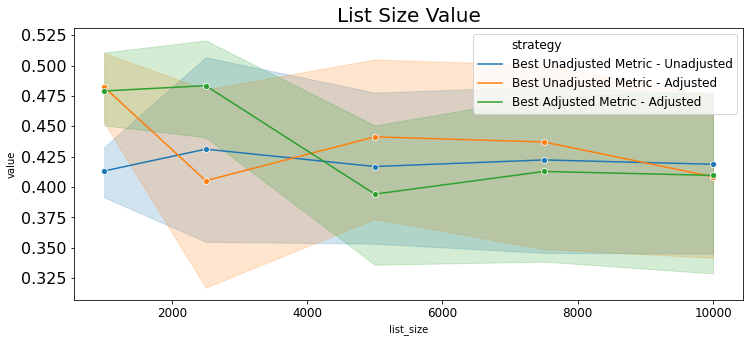

In [88]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)

Text(0.5, 1.0, 'Max  Recall Ratio')

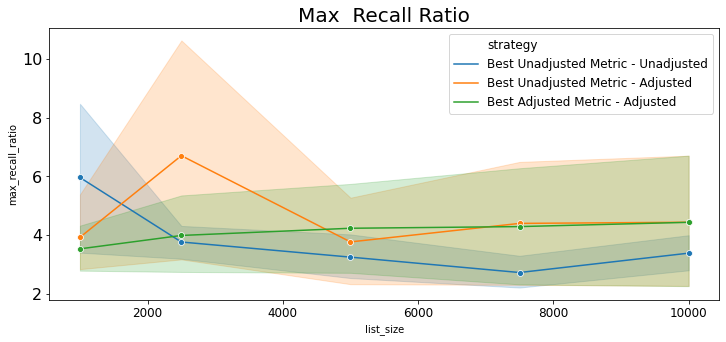

In [89]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("Max  Recall Ratio", fontsize=20)

Text(0.5, 1.0, 'Recall-rural to urban')

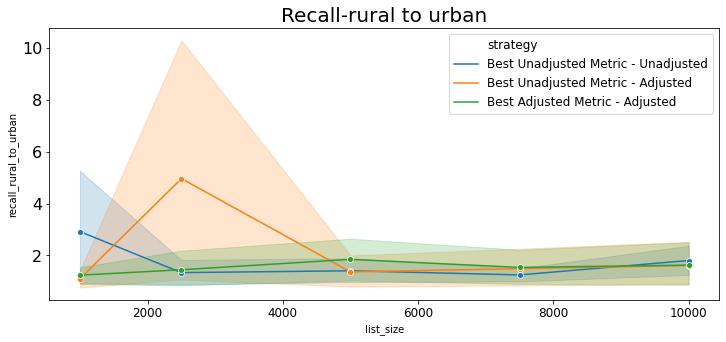

In [90]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_rural_to_urban', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("Recall-rural to urban", fontsize=20)

Text(0.5, 1.0, 'Recall: Urban to Rural')

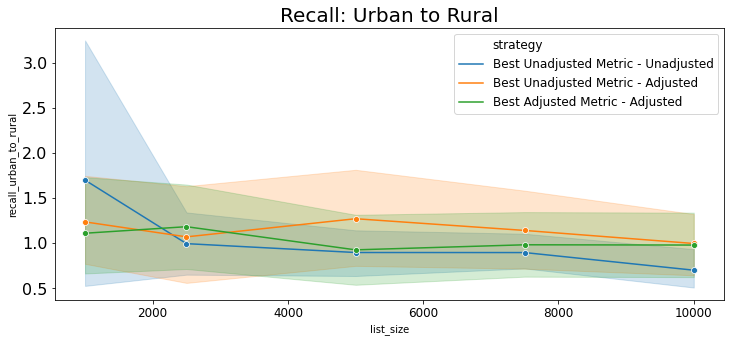

In [91]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_urban_to_rural', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("Recall: Urban to Rural", fontsize=20)

In [92]:
query = "SELECT * from bias_analysis.model_adjustment_results_rural"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['model_id', 'model_group_id', 'train_end_time', 'list_size',
       'past_train_end_time', 'metric', 'parameter', 'base_value',
       'base_max_recall_ratio', 'base_recall_rural_to_urban',
       'base_recall_urban_to_rural', 'base_frac_rural', 'base_recall_rural',
       'base_frac_urban', 'base_recall_urban', 'adj_value',
       'adj_max_recall_ratio', 'adj_recall_rural_to_urban',
       'adj_recall_urban_to_rural', 'adj_frac_rural', 'adj_recall_rural',
       'adj_frac_urban', 'adj_recall_urban', 'value_diff',
       'recall_ratio_diff'],
      dtype='object')


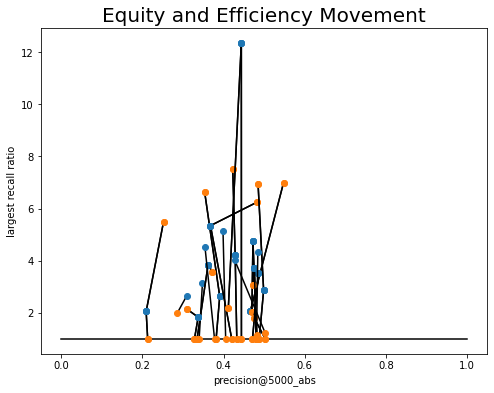

In [93]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@5000_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

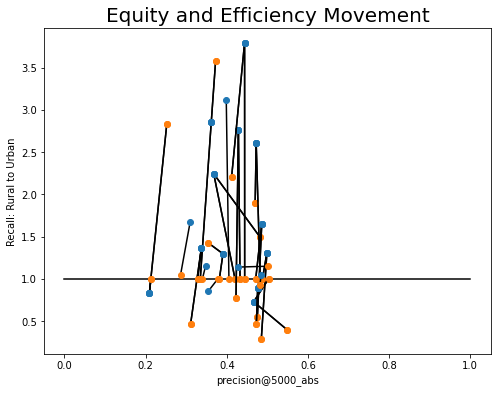

In [95]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_recall_rural_to_urban', 'adj_value', 'adj_recall_rural_to_urban']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@5000_abs')
ax.set_ylabel('Recall: Rural to Urban')
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

Text(0.5, 1.0, 'Value over Time')

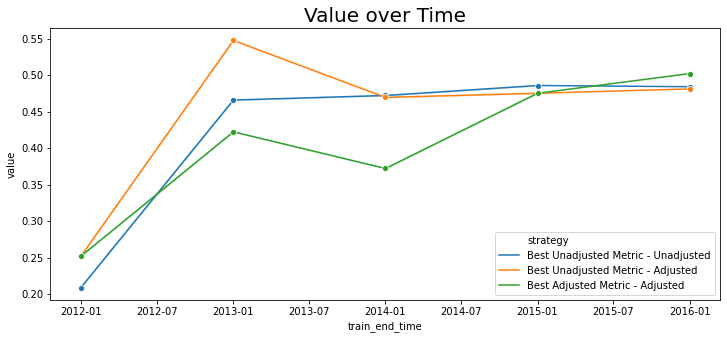

In [103]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df[ts_df['list_size']==5000], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value over Time", fontsize=20)